<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[04:10:08] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


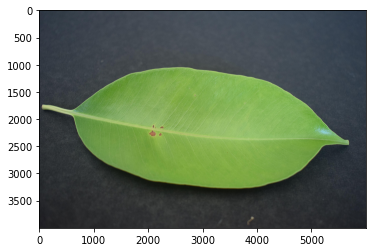

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

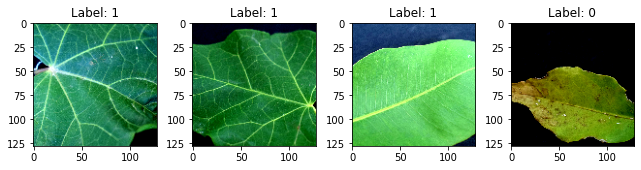

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[04:10:16] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[04:10:17] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2881685959642153 samples/sec                   batch loss = 0.1964733600616455 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2954789932720434 samples/sec                   batch loss = 1.276318907737732 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.296207038150582 samples/sec                   batch loss = 0.5376425981521606 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2968830682140735 samples/sec                   batch loss = 0.7086344957351685 | accuracy = 0.5125


Epoch[1] Batch[25] Speed: 1.29231381661874 samples/sec                   batch loss = 0.9902271628379822 | accuracy = 0.49


Epoch[1] Batch[30] Speed: 1.2928224886724409 samples/sec                   batch loss = 0.6317616105079651 | accuracy = 0.5083333333333333


Epoch[1] Batch[35] Speed: 1.2917580017206793 samples/sec                   batch loss = 0.8215857744216919 | accuracy = 0.5142857142857142


Epoch[1] Batch[40] Speed: 1.2917549185108477 samples/sec                   batch loss = 0.9724075794219971 | accuracy = 0.525


Epoch[1] Batch[45] Speed: 1.2938663795729533 samples/sec                   batch loss = 0.8122956156730652 | accuracy = 0.5333333333333333


Epoch[1] Batch[50] Speed: 1.2998283523491245 samples/sec                   batch loss = 0.6578097939491272 | accuracy = 0.55


Epoch[1] Batch[55] Speed: 1.2968038760309486 samples/sec                   batch loss = 0.6417674422264099 | accuracy = 0.5454545454545454


Epoch[1] Batch[60] Speed: 1.2994220330097122 samples/sec                   batch loss = 0.39053747057914734 | accuracy = 0.55


Epoch[1] Batch[65] Speed: 1.2986193030071664 samples/sec                   batch loss = 0.576374888420105 | accuracy = 0.5538461538461539


Epoch[1] Batch[70] Speed: 1.300061426084784 samples/sec                   batch loss = 0.3059145510196686 | accuracy = 0.5678571428571428


Epoch[1] Batch[75] Speed: 1.3010780964845132 samples/sec                   batch loss = 0.9935487508773804 | accuracy = 0.57


Epoch[1] Batch[80] Speed: 1.2935738803370511 samples/sec                   batch loss = 0.42172908782958984 | accuracy = 0.56875


Epoch[1] Batch[85] Speed: 1.2979546163482154 samples/sec                   batch loss = 0.5479477643966675 | accuracy = 0.5735294117647058


Epoch[1] Batch[90] Speed: 1.2964059564516133 samples/sec                   batch loss = 0.8170514106750488 | accuracy = 0.5666666666666667


Epoch[1] Batch[95] Speed: 1.2943762748211605 samples/sec                   batch loss = 0.7153422832489014 | accuracy = 0.5710526315789474


Epoch[1] Batch[100] Speed: 1.2936623543858228 samples/sec                   batch loss = 0.4478834569454193 | accuracy = 0.57


Epoch[1] Batch[105] Speed: 1.291755714176492 samples/sec                   batch loss = 0.5602145791053772 | accuracy = 0.569047619047619


Epoch[1] Batch[110] Speed: 1.2942193104569752 samples/sec                   batch loss = 0.25178372859954834 | accuracy = 0.5772727272727273


Epoch[1] Batch[115] Speed: 1.288882008930715 samples/sec                   batch loss = 0.33817058801651 | accuracy = 0.5760869565217391


Epoch[1] Batch[120] Speed: 1.296411766664959 samples/sec                   batch loss = 0.3653653860092163 | accuracy = 0.5791666666666667


Epoch[1] Batch[125] Speed: 1.2920332623623936 samples/sec                   batch loss = 0.6099405884742737 | accuracy = 0.58


Epoch[1] Batch[130] Speed: 1.291185075918196 samples/sec                   batch loss = 0.7548564076423645 | accuracy = 0.5826923076923077


Epoch[1] Batch[135] Speed: 1.2932743354372955 samples/sec                   batch loss = 0.45723798871040344 | accuracy = 0.5851851851851851


Epoch[1] Batch[140] Speed: 1.291097536518805 samples/sec                   batch loss = 1.281320333480835 | accuracy = 0.5875


Epoch[1] Batch[145] Speed: 1.294182970446848 samples/sec                   batch loss = 0.9898991584777832 | accuracy = 0.5862068965517241


Epoch[1] Batch[150] Speed: 1.2885133779175597 samples/sec                   batch loss = 0.509836733341217 | accuracy = 0.59


Epoch[1] Batch[155] Speed: 1.2896975272749411 samples/sec                   batch loss = 0.4441206157207489 | accuracy = 0.5919354838709677


Epoch[1] Batch[160] Speed: 1.2924964065256785 samples/sec                   batch loss = 0.7684891223907471 | accuracy = 0.5921875


Epoch[1] Batch[165] Speed: 1.2930603315824283 samples/sec                   batch loss = 0.5472741723060608 | accuracy = 0.5984848484848485


Epoch[1] Batch[170] Speed: 1.2937909476054186 samples/sec                   batch loss = 0.37306734919548035 | accuracy = 0.6014705882352941


Epoch[1] Batch[175] Speed: 1.2918377724589925 samples/sec                   batch loss = 1.0382275581359863 | accuracy = 0.6042857142857143


Epoch[1] Batch[180] Speed: 1.2893243672251617 samples/sec                   batch loss = 1.0271692276000977 | accuracy = 0.6069444444444444


Epoch[1] Batch[185] Speed: 1.2942468663305593 samples/sec                   batch loss = 0.7429797053337097 | accuracy = 0.6108108108108108


Epoch[1] Batch[190] Speed: 1.2951369726545658 samples/sec                   batch loss = 0.7250386476516724 | accuracy = 0.6118421052631579


Epoch[1] Batch[195] Speed: 1.2898667841629432 samples/sec                   batch loss = 0.6086053252220154 | accuracy = 0.6089743589743589


Epoch[1] Batch[200] Speed: 1.2968899854589715 samples/sec                   batch loss = 0.9269352555274963 | accuracy = 0.61375


Epoch[1] Batch[205] Speed: 1.2981758685699938 samples/sec                   batch loss = 0.11126972734928131 | accuracy = 0.6182926829268293


Epoch[1] Batch[210] Speed: 1.2972651309179373 samples/sec                   batch loss = 0.2497815638780594 | accuracy = 0.625


Epoch[1] Batch[215] Speed: 1.3027324183083069 samples/sec                   batch loss = 0.7158899903297424 | accuracy = 0.6244186046511628


Epoch[1] Batch[220] Speed: 1.2982308166948306 samples/sec                   batch loss = 0.5927071571350098 | accuracy = 0.6261363636363636


Epoch[1] Batch[225] Speed: 1.2942183120777857 samples/sec                   batch loss = 0.4418010711669922 | accuracy = 0.6288888888888889


Epoch[1] Batch[230] Speed: 1.3010177616842524 samples/sec                   batch loss = 0.23052071034908295 | accuracy = 0.6315217391304347


Epoch[1] Batch[235] Speed: 1.3023526892107327 samples/sec                   batch loss = 1.0970033407211304 | accuracy = 0.6340425531914894


Epoch[1] Batch[240] Speed: 1.2939300446117459 samples/sec                   batch loss = 0.7927637696266174 | accuracy = 0.634375


Epoch[1] Batch[245] Speed: 1.305778851215821 samples/sec                   batch loss = 0.36693671345710754 | accuracy = 0.6357142857142857


Epoch[1] Batch[250] Speed: 1.295694298856302 samples/sec                   batch loss = 0.5741162896156311 | accuracy = 0.633


Epoch[1] Batch[255] Speed: 1.3022147067256502 samples/sec                   batch loss = 0.8337924480438232 | accuracy = 0.6333333333333333


Epoch[1] Batch[260] Speed: 1.2990001768419983 samples/sec                   batch loss = 0.581924319267273 | accuracy = 0.6336538461538461


Epoch[1] Batch[265] Speed: 1.304617549489019 samples/sec                   batch loss = 0.543988823890686 | accuracy = 0.6358490566037736


Epoch[1] Batch[270] Speed: 1.2958026790647725 samples/sec                   batch loss = 2.3241729736328125 | accuracy = 0.6342592592592593


Epoch[1] Batch[275] Speed: 1.2970096955580097 samples/sec                   batch loss = 0.4511227011680603 | accuracy = 0.6363636363636364


Epoch[1] Batch[280] Speed: 1.3004034322395601 samples/sec                   batch loss = 1.0553017854690552 | accuracy = 0.6392857142857142


Epoch[1] Batch[285] Speed: 1.2935460539103454 samples/sec                   batch loss = 0.359921395778656 | accuracy = 0.6385964912280702


Epoch[1] Batch[290] Speed: 1.3014266949842466 samples/sec                   batch loss = 0.7823504209518433 | accuracy = 0.6387931034482759


Epoch[1] Batch[295] Speed: 1.2982640690989196 samples/sec                   batch loss = 0.6710018515586853 | accuracy = 0.6415254237288136


Epoch[1] Batch[300] Speed: 1.2960357128676296 samples/sec                   batch loss = 0.5322359800338745 | accuracy = 0.6383333333333333


Epoch[1] Batch[305] Speed: 1.3010020230914223 samples/sec                   batch loss = 0.46737977862358093 | accuracy = 0.6368852459016393


Epoch[1] Batch[310] Speed: 1.2969192592542775 samples/sec                   batch loss = 0.8042996525764465 | accuracy = 0.6370967741935484


Epoch[1] Batch[315] Speed: 1.302191055521042 samples/sec                   batch loss = 0.47895216941833496 | accuracy = 0.6373015873015873


Epoch[1] Batch[320] Speed: 1.3006673654843748 samples/sec                   batch loss = 1.016573190689087 | accuracy = 0.6359375


Epoch[1] Batch[325] Speed: 1.304789933625101 samples/sec                   batch loss = 0.21654489636421204 | accuracy = 0.6353846153846154


Epoch[1] Batch[330] Speed: 1.2964744802133124 samples/sec                   batch loss = 0.5060127377510071 | accuracy = 0.6363636363636364


Epoch[1] Batch[335] Speed: 1.2938574988977636 samples/sec                   batch loss = 0.6641950607299805 | accuracy = 0.6365671641791045


Epoch[1] Batch[340] Speed: 1.2907791760461798 samples/sec                   batch loss = 0.5139267444610596 | accuracy = 0.638235294117647


Epoch[1] Batch[345] Speed: 1.2939367308022311 samples/sec                   batch loss = 0.587939977645874 | accuracy = 0.6376811594202898


Epoch[1] Batch[350] Speed: 1.293823573845281 samples/sec                   batch loss = 0.5579953789710999 | accuracy = 0.6357142857142857


Epoch[1] Batch[355] Speed: 1.2921156544531207 samples/sec                   batch loss = 0.5350705981254578 | accuracy = 0.6380281690140845


Epoch[1] Batch[360] Speed: 1.2961315332914247 samples/sec                   batch loss = 0.8609529137611389 | accuracy = 0.6395833333333333


Epoch[1] Batch[365] Speed: 1.2968414660512424 samples/sec                   batch loss = 0.3232233226299286 | accuracy = 0.6417808219178082


Epoch[1] Batch[370] Speed: 1.2941009134258639 samples/sec                   batch loss = 0.7580934762954712 | accuracy = 0.6425675675675676


Epoch[1] Batch[375] Speed: 1.2908365785923315 samples/sec                   batch loss = 0.6200725436210632 | accuracy = 0.644


Epoch[1] Batch[380] Speed: 1.3004400216290226 samples/sec                   batch loss = 0.40554162859916687 | accuracy = 0.6460526315789473


Epoch[1] Batch[385] Speed: 1.2898574624754873 samples/sec                   batch loss = 1.1830500364303589 | accuracy = 0.6467532467532467


Epoch[1] Batch[390] Speed: 1.2912318810798213 samples/sec                   batch loss = 1.0376900434494019 | accuracy = 0.6467948717948718


Epoch[1] Batch[395] Speed: 1.2942859058268499 samples/sec                   batch loss = 0.45905983448028564 | accuracy = 0.649367088607595


Epoch[1] Batch[400] Speed: 1.2902480971258146 samples/sec                   batch loss = 1.0623624324798584 | accuracy = 0.6475


Epoch[1] Batch[405] Speed: 1.2960635463896246 samples/sec                   batch loss = 0.6407842040061951 | accuracy = 0.6469135802469136


Epoch[1] Batch[410] Speed: 1.2949927181236132 samples/sec                   batch loss = 0.8111767172813416 | accuracy = 0.6451219512195122


Epoch[1] Batch[415] Speed: 1.294770850813325 samples/sec                   batch loss = 0.40099823474884033 | accuracy = 0.6457831325301204


Epoch[1] Batch[420] Speed: 1.294713897147468 samples/sec                   batch loss = 0.6369655132293701 | accuracy = 0.6476190476190476


Epoch[1] Batch[425] Speed: 1.294984721584571 samples/sec                   batch loss = 0.45760685205459595 | accuracy = 0.6511764705882352


Epoch[1] Batch[430] Speed: 1.2918314063525533 samples/sec                   batch loss = 0.42741259932518005 | accuracy = 0.6523255813953488


Epoch[1] Batch[435] Speed: 1.3012765950845777 samples/sec                   batch loss = 0.545928955078125 | accuracy = 0.6522988505747126


Epoch[1] Batch[440] Speed: 1.2933373440125118 samples/sec                   batch loss = 0.3633904457092285 | accuracy = 0.6534090909090909


Epoch[1] Batch[445] Speed: 1.2918735829768413 samples/sec                   batch loss = 0.3958118259906769 | accuracy = 0.6539325842696629


Epoch[1] Batch[450] Speed: 1.2947384765360324 samples/sec                   batch loss = 0.7559308409690857 | accuracy = 0.6544444444444445


Epoch[1] Batch[455] Speed: 1.292616003993444 samples/sec                   batch loss = 0.9914807677268982 | accuracy = 0.6538461538461539


Epoch[1] Batch[460] Speed: 1.2978244913973531 samples/sec                   batch loss = 0.28241899609565735 | accuracy = 0.654891304347826


Epoch[1] Batch[465] Speed: 1.290282033394318 samples/sec                   batch loss = 0.510166347026825 | accuracy = 0.6559139784946236


Epoch[1] Batch[470] Speed: 1.295918785088498 samples/sec                   batch loss = 0.8757210373878479 | accuracy = 0.6574468085106383


Epoch[1] Batch[475] Speed: 1.2984160874290145 samples/sec                   batch loss = 0.3120708465576172 | accuracy = 0.6573684210526316


Epoch[1] Batch[480] Speed: 1.2947923346378847 samples/sec                   batch loss = 0.3229326605796814 | accuracy = 0.6583333333333333


Epoch[1] Batch[485] Speed: 1.2968246254526983 samples/sec                   batch loss = 1.2615262269973755 | accuracy = 0.6587628865979381


Epoch[1] Batch[490] Speed: 1.29616297589069 samples/sec                   batch loss = 0.2220659703016281 | accuracy = 0.6576530612244897


Epoch[1] Batch[495] Speed: 1.2966568448062323 samples/sec                   batch loss = 0.5033435225486755 | accuracy = 0.6590909090909091


Epoch[1] Batch[500] Speed: 1.2957092088158682 samples/sec                   batch loss = 0.25403812527656555 | accuracy = 0.6595


Epoch[1] Batch[505] Speed: 1.295503501683044 samples/sec                   batch loss = 0.20353814959526062 | accuracy = 0.6608910891089109


Epoch[1] Batch[510] Speed: 1.3001196572043114 samples/sec                   batch loss = 0.27865973114967346 | accuracy = 0.6612745098039216


Epoch[1] Batch[515] Speed: 1.2931080701329256 samples/sec                   batch loss = 0.2975395619869232 | accuracy = 0.6621359223300971


Epoch[1] Batch[520] Speed: 1.293299458373746 samples/sec                   batch loss = 0.40732330083847046 | accuracy = 0.6639423076923077


Epoch[1] Batch[525] Speed: 1.295669783225814 samples/sec                   batch loss = 0.6575307846069336 | accuracy = 0.6623809523809524


Epoch[1] Batch[530] Speed: 1.295485795513555 samples/sec                   batch loss = 0.4623102843761444 | accuracy = 0.6632075471698113


Epoch[1] Batch[535] Speed: 1.2935241127693018 samples/sec                   batch loss = 0.4976734519004822 | accuracy = 0.6644859813084112


Epoch[1] Batch[540] Speed: 1.2991332537979046 samples/sec                   batch loss = 0.635924220085144 | accuracy = 0.6652777777777777


Epoch[1] Batch[545] Speed: 1.2998916990389278 samples/sec                   batch loss = 0.667065441608429 | accuracy = 0.6669724770642201


Epoch[1] Batch[550] Speed: 1.291676351355773 samples/sec                   batch loss = 0.5215237140655518 | accuracy = 0.6686363636363636


Epoch[1] Batch[555] Speed: 1.2948978655415189 samples/sec                   batch loss = 0.7041638493537903 | accuracy = 0.6693693693693694


Epoch[1] Batch[560] Speed: 1.2974291559982842 samples/sec                   batch loss = 0.26057344675064087 | accuracy = 0.6696428571428571


Epoch[1] Batch[565] Speed: 1.2928394247374013 samples/sec                   batch loss = 0.5543199777603149 | accuracy = 0.6699115044247788


Epoch[1] Batch[570] Speed: 1.2916038592567933 samples/sec                   batch loss = 1.2951881885528564 | accuracy = 0.6679824561403509


Epoch[1] Batch[575] Speed: 1.291225620320214 samples/sec                   batch loss = 0.37497323751449585 | accuracy = 0.6691304347826087


Epoch[1] Batch[580] Speed: 1.2972887038360574 samples/sec                   batch loss = 0.4655396044254303 | accuracy = 0.6685344827586207


Epoch[1] Batch[585] Speed: 1.2976819461714506 samples/sec                   batch loss = 0.3160037398338318 | accuracy = 0.6696581196581196


Epoch[1] Batch[590] Speed: 1.293670135095299 samples/sec                   batch loss = 0.3747064769268036 | accuracy = 0.6711864406779661


Epoch[1] Batch[595] Speed: 1.296594614638061 samples/sec                   batch loss = 0.8895196318626404 | accuracy = 0.6714285714285714


Epoch[1] Batch[600] Speed: 1.3013913623694155 samples/sec                   batch loss = 0.9024780988693237 | accuracy = 0.6704166666666667


Epoch[1] Batch[605] Speed: 1.295205862280867 samples/sec                   batch loss = 0.40197959542274475 | accuracy = 0.6706611570247933


Epoch[1] Batch[610] Speed: 1.29646846906718 samples/sec                   batch loss = 0.5193831920623779 | accuracy = 0.6725409836065573


Epoch[1] Batch[615] Speed: 1.2988057906623283 samples/sec                   batch loss = 0.540762186050415 | accuracy = 0.6719512195121952


Epoch[1] Batch[620] Speed: 1.3071967982544546 samples/sec                   batch loss = 0.45012804865837097 | accuracy = 0.6717741935483871


Epoch[1] Batch[625] Speed: 1.3004977826244044 samples/sec                   batch loss = 0.6783051490783691 | accuracy = 0.6724


Epoch[1] Batch[630] Speed: 1.3046274915385379 samples/sec                   batch loss = 0.9811549782752991 | accuracy = 0.6730158730158731


Epoch[1] Batch[635] Speed: 1.2973082649929695 samples/sec                   batch loss = 0.48383593559265137 | accuracy = 0.6728346456692913


Epoch[1] Batch[640] Speed: 1.2893033617132168 samples/sec                   batch loss = 0.393278032541275 | accuracy = 0.67421875


Epoch[1] Batch[645] Speed: 1.2910060352620096 samples/sec                   batch loss = 0.42979004979133606 | accuracy = 0.6744186046511628


Epoch[1] Batch[650] Speed: 1.2952455596315982 samples/sec                   batch loss = 0.2746292054653168 | accuracy = 0.6746153846153846


Epoch[1] Batch[655] Speed: 1.291510596070231 samples/sec                   batch loss = 0.7566521763801575 | accuracy = 0.6748091603053435


Epoch[1] Batch[660] Speed: 1.2934311703724581 samples/sec                   batch loss = 0.31079035997390747 | accuracy = 0.6757575757575758


Epoch[1] Batch[665] Speed: 1.2923423864435284 samples/sec                   batch loss = 0.7119433283805847 | accuracy = 0.6763157894736842


Epoch[1] Batch[670] Speed: 1.300538006662216 samples/sec                   batch loss = 0.3422302007675171 | accuracy = 0.6764925373134328


Epoch[1] Batch[675] Speed: 1.299810326359213 samples/sec                   batch loss = 0.5006591081619263 | accuracy = 0.6774074074074075


Epoch[1] Batch[680] Speed: 1.303059941771982 samples/sec                   batch loss = 0.24714887142181396 | accuracy = 0.6783088235294118


Epoch[1] Batch[685] Speed: 1.297029649389808 samples/sec                   batch loss = 0.5178316235542297 | accuracy = 0.6788321167883211


Epoch[1] Batch[690] Speed: 1.2995456335108513 samples/sec                   batch loss = 0.3126447796821594 | accuracy = 0.6793478260869565


Epoch[1] Batch[695] Speed: 1.3021357716547235 samples/sec                   batch loss = 0.3370186388492584 | accuracy = 0.6809352517985612


Epoch[1] Batch[700] Speed: 1.300646291248299 samples/sec                   batch loss = 0.7979645133018494 | accuracy = 0.6814285714285714


Epoch[1] Batch[705] Speed: 1.2994756775705965 samples/sec                   batch loss = 0.4416556656360626 | accuracy = 0.6815602836879433


Epoch[1] Batch[710] Speed: 1.300741181112368 samples/sec                   batch loss = 0.41445237398147583 | accuracy = 0.6816901408450704


Epoch[1] Batch[715] Speed: 1.2951266748349868 samples/sec                   batch loss = 0.5671923756599426 | accuracy = 0.6821678321678322


Epoch[1] Batch[720] Speed: 1.295651372096985 samples/sec                   batch loss = 0.2793486416339874 | accuracy = 0.6819444444444445


Epoch[1] Batch[725] Speed: 1.2939012049699912 samples/sec                   batch loss = 0.5590263605117798 | accuracy = 0.6817241379310345


Epoch[1] Batch[730] Speed: 1.2885074403684176 samples/sec                   batch loss = 0.5035441517829895 | accuracy = 0.6821917808219178


Epoch[1] Batch[735] Speed: 1.292468029026654 samples/sec                   batch loss = 0.3618006110191345 | accuracy = 0.6829931972789116


Epoch[1] Batch[740] Speed: 1.2957902689620326 samples/sec                   batch loss = 0.6242133975028992 | accuracy = 0.6831081081081081


Epoch[1] Batch[745] Speed: 1.296791246273232 samples/sec                   batch loss = 0.3813609778881073 | accuracy = 0.6825503355704698


Epoch[1] Batch[750] Speed: 1.2990552953572514 samples/sec                   batch loss = 0.2094648778438568 | accuracy = 0.683


Epoch[1] Batch[755] Speed: 1.3029996254225258 samples/sec                   batch loss = 0.6201803684234619 | accuracy = 0.6824503311258279


Epoch[1] Batch[760] Speed: 1.3001689260140017 samples/sec                   batch loss = 0.5189679265022278 | accuracy = 0.6828947368421052


Epoch[1] Batch[765] Speed: 1.2990292442351818 samples/sec                   batch loss = 0.7767094969749451 | accuracy = 0.6826797385620915


Epoch[1] Batch[770] Speed: 1.303609928131823 samples/sec                   batch loss = 0.6328082084655762 | accuracy = 0.6827922077922078


Epoch[1] Batch[775] Speed: 1.3008325546814443 samples/sec                   batch loss = 0.3691168427467346 | accuracy = 0.6838709677419355


Epoch[1] Batch[780] Speed: 1.3028894309435557 samples/sec                   batch loss = 0.5441797971725464 | accuracy = 0.6836538461538462


Epoch[1] Batch[785] Speed: 1.2962119452694552 samples/sec                   batch loss = 0.42993423342704773 | accuracy = 0.6847133757961783


[Epoch 1] training: accuracy=0.6852791878172588
[Epoch 1] time cost: 634.847972869873
[Epoch 1] validation: validation accuracy=0.7322222222222222


Epoch[2] Batch[5] Speed: 1.2973397647110496 samples/sec                   batch loss = 0.6310845017433167 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2981774757617206 samples/sec                   batch loss = 0.49305200576782227 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.2980783395705078 samples/sec                   batch loss = 0.3649024963378906 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.3004763106604664 samples/sec                   batch loss = 0.4417922794818878 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.3032169321408447 samples/sec                   batch loss = 0.4045875072479248 | accuracy = 0.72


Epoch[2] Batch[30] Speed: 1.3016704413356237 samples/sec                   batch loss = 0.6541825532913208 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.3022470516441385 samples/sec                   batch loss = 0.6025234460830688 | accuracy = 0.7285714285714285


Epoch[2] Batch[40] Speed: 1.3055029856858735 samples/sec                   batch loss = 0.22806484997272491 | accuracy = 0.7375


Epoch[2] Batch[45] Speed: 1.3007896902056146 samples/sec                   batch loss = 0.5636171102523804 | accuracy = 0.7222222222222222


Epoch[2] Batch[50] Speed: 1.304422797039262 samples/sec                   batch loss = 0.8120148777961731 | accuracy = 0.72


Epoch[2] Batch[55] Speed: 1.29907299864651 samples/sec                   batch loss = 0.15865740180015564 | accuracy = 0.7272727272727273


Epoch[2] Batch[60] Speed: 1.2981542723171797 samples/sec                   batch loss = 0.6014981865882874 | accuracy = 0.7208333333333333


Epoch[2] Batch[65] Speed: 1.3005241951206126 samples/sec                   batch loss = 0.2982911169528961 | accuracy = 0.7269230769230769


Epoch[2] Batch[70] Speed: 1.297346084902425 samples/sec                   batch loss = 0.2156040221452713 | accuracy = 0.7392857142857143


Epoch[2] Batch[75] Speed: 1.3053108123889416 samples/sec                   batch loss = 0.5264874696731567 | accuracy = 0.7333333333333333


Epoch[2] Batch[80] Speed: 1.307991917170882 samples/sec                   batch loss = 0.6368425488471985 | accuracy = 0.721875


Epoch[2] Batch[85] Speed: 1.2981656228162843 samples/sec                   batch loss = 0.34823599457740784 | accuracy = 0.7205882352941176


Epoch[2] Batch[90] Speed: 1.3006070687708162 samples/sec                   batch loss = 0.63047194480896 | accuracy = 0.7194444444444444


Epoch[2] Batch[95] Speed: 1.302362192377464 samples/sec                   batch loss = 0.6497139930725098 | accuracy = 0.7236842105263158


Epoch[2] Batch[100] Speed: 1.2997951204659897 samples/sec                   batch loss = 0.4983278512954712 | accuracy = 0.725


Epoch[2] Batch[105] Speed: 1.3005071579296272 samples/sec                   batch loss = 0.2634631395339966 | accuracy = 0.7309523809523809


Epoch[2] Batch[110] Speed: 1.2980892869978344 samples/sec                   batch loss = 0.41870054602622986 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.2965221706146186 samples/sec                   batch loss = 0.5384319424629211 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.3085992513382998 samples/sec                   batch loss = 0.36521342396736145 | accuracy = 0.7395833333333334


Epoch[2] Batch[125] Speed: 1.298723850136768 samples/sec                   batch loss = 0.44916579127311707 | accuracy = 0.736


Epoch[2] Batch[130] Speed: 1.300720407014729 samples/sec                   batch loss = 0.3016526401042938 | accuracy = 0.7384615384615385


Epoch[2] Batch[135] Speed: 1.2983701667057352 samples/sec                   batch loss = 0.29086393117904663 | accuracy = 0.7351851851851852


Epoch[2] Batch[140] Speed: 1.3045996947601055 samples/sec                   batch loss = 0.9825645089149475 | accuracy = 0.7267857142857143


Epoch[2] Batch[145] Speed: 1.3019879331166926 samples/sec                   batch loss = 0.7181575894355774 | accuracy = 0.7241379310344828


Epoch[2] Batch[150] Speed: 1.29623127367048 samples/sec                   batch loss = 0.8817370533943176 | accuracy = 0.725


Epoch[2] Batch[155] Speed: 1.2956375640937325 samples/sec                   batch loss = 0.3905778229236603 | accuracy = 0.7225806451612903


Epoch[2] Batch[160] Speed: 1.2992336579349304 samples/sec                   batch loss = 0.6499566435813904 | accuracy = 0.721875


Epoch[2] Batch[165] Speed: 1.3036284648432006 samples/sec                   batch loss = 0.28413280844688416 | accuracy = 0.7242424242424242


Epoch[2] Batch[170] Speed: 1.2962162515472382 samples/sec                   batch loss = 0.3710653781890869 | accuracy = 0.7279411764705882


Epoch[2] Batch[175] Speed: 1.3003200806301227 samples/sec                   batch loss = 0.6412621140480042 | accuracy = 0.7228571428571429


Epoch[2] Batch[180] Speed: 1.2959004669800671 samples/sec                   batch loss = 0.2808898687362671 | accuracy = 0.725


Epoch[2] Batch[185] Speed: 1.300951480570268 samples/sec                   batch loss = 0.29246872663497925 | accuracy = 0.7256756756756757


Epoch[2] Batch[190] Speed: 1.3011524632933462 samples/sec                   batch loss = 0.3339938819408417 | accuracy = 0.7263157894736842


Epoch[2] Batch[195] Speed: 1.294403138314341 samples/sec                   batch loss = 0.2004740834236145 | accuracy = 0.7282051282051282


Epoch[2] Batch[200] Speed: 1.2994677262210033 samples/sec                   batch loss = 0.5217478275299072 | accuracy = 0.725


Epoch[2] Batch[205] Speed: 1.2995963688612446 samples/sec                   batch loss = 0.2787502110004425 | accuracy = 0.7219512195121951


Epoch[2] Batch[210] Speed: 1.3006585928725105 samples/sec                   batch loss = 0.9692736268043518 | accuracy = 0.7202380952380952


Epoch[2] Batch[215] Speed: 1.2998410413345989 samples/sec                   batch loss = 1.2263725996017456 | accuracy = 0.7186046511627907


Epoch[2] Batch[220] Speed: 1.2994742684635745 samples/sec                   batch loss = 0.5218842029571533 | accuracy = 0.7170454545454545


Epoch[2] Batch[225] Speed: 1.2988742666878073 samples/sec                   batch loss = 0.23327283561229706 | accuracy = 0.7222222222222222


Epoch[2] Batch[230] Speed: 1.2951037802694865 samples/sec                   batch loss = 0.46440309286117554 | accuracy = 0.716304347826087


Epoch[2] Batch[235] Speed: 1.3028917580906658 samples/sec                   batch loss = 0.4432830512523651 | accuracy = 0.7170212765957447


Epoch[2] Batch[240] Speed: 1.298908557689665 samples/sec                   batch loss = 0.27905911207199097 | accuracy = 0.7208333333333333


Epoch[2] Batch[245] Speed: 1.2972088603087886 samples/sec                   batch loss = 0.7318042516708374 | accuracy = 0.7193877551020408


Epoch[2] Batch[250] Speed: 1.299705503554835 samples/sec                   batch loss = 0.35708990693092346 | accuracy = 0.721


Epoch[2] Batch[255] Speed: 1.3000559860736094 samples/sec                   batch loss = 0.38012000918388367 | accuracy = 0.7225490196078431


Epoch[2] Batch[260] Speed: 1.3059006145912453 samples/sec                   batch loss = 0.06286782771348953 | accuracy = 0.7240384615384615


Epoch[2] Batch[265] Speed: 1.2997879707981062 samples/sec                   batch loss = 0.40279722213745117 | accuracy = 0.7226415094339622


Epoch[2] Batch[270] Speed: 1.2995844899915001 samples/sec                   batch loss = 0.2685368061065674 | accuracy = 0.7240740740740741


Epoch[2] Batch[275] Speed: 1.2961959221615669 samples/sec                   batch loss = 0.3173200190067291 | accuracy = 0.7272727272727273


Epoch[2] Batch[280] Speed: 1.3014308340732346 samples/sec                   batch loss = 0.5595792531967163 | accuracy = 0.7258928571428571


Epoch[2] Batch[285] Speed: 1.302776624868138 samples/sec                   batch loss = 0.3724212646484375 | accuracy = 0.7263157894736842


Epoch[2] Batch[290] Speed: 1.3018213392129347 samples/sec                   batch loss = 0.4648743271827698 | accuracy = 0.725


Epoch[2] Batch[295] Speed: 1.301290523543771 samples/sec                   batch loss = 0.30644187331199646 | accuracy = 0.726271186440678


Epoch[2] Batch[300] Speed: 1.3024512660327847 samples/sec                   batch loss = 0.6948608756065369 | accuracy = 0.7266666666666667


Epoch[2] Batch[305] Speed: 1.302442671562221 samples/sec                   batch loss = 0.4273754358291626 | accuracy = 0.728688524590164


Epoch[2] Batch[310] Speed: 1.3076758735933234 samples/sec                   batch loss = 0.45835956931114197 | accuracy = 0.7298387096774194


Epoch[2] Batch[315] Speed: 1.3023990942865185 samples/sec                   batch loss = 1.0273666381835938 | accuracy = 0.7277777777777777


Epoch[2] Batch[320] Speed: 1.2970686563919411 samples/sec                   batch loss = 0.6275038719177246 | accuracy = 0.7265625


Epoch[2] Batch[325] Speed: 1.2965126522921016 samples/sec                   batch loss = 0.22696423530578613 | accuracy = 0.7284615384615385


Epoch[2] Batch[330] Speed: 1.3018777076352588 samples/sec                   batch loss = 0.3928050398826599 | accuracy = 0.728030303030303


Epoch[2] Batch[335] Speed: 1.297173054280933 samples/sec                   batch loss = 0.37126392126083374 | accuracy = 0.7268656716417911


Epoch[2] Batch[340] Speed: 1.3028763788377455 samples/sec                   batch loss = 0.41086310148239136 | accuracy = 0.7272058823529411


Epoch[2] Batch[345] Speed: 1.3006964066989692 samples/sec                   batch loss = 0.6125031113624573 | accuracy = 0.7275362318840579


Epoch[2] Batch[350] Speed: 1.3035338622301245 samples/sec                   batch loss = 0.1799003630876541 | accuracy = 0.7292857142857143


Epoch[2] Batch[355] Speed: 1.3115334581346978 samples/sec                   batch loss = 0.6488859057426453 | accuracy = 0.7274647887323944


Epoch[2] Batch[360] Speed: 1.305369210022542 samples/sec                   batch loss = 0.8385418653488159 | accuracy = 0.7270833333333333


Epoch[2] Batch[365] Speed: 1.3023910060179207 samples/sec                   batch loss = 0.25864648818969727 | accuracy = 0.726027397260274


Epoch[2] Batch[370] Speed: 1.300433167261596 samples/sec                   batch loss = 0.15533912181854248 | accuracy = 0.727027027027027


Epoch[2] Batch[375] Speed: 1.3041351364166711 samples/sec                   batch loss = 0.4682181477546692 | accuracy = 0.7273333333333334


Epoch[2] Batch[380] Speed: 1.3051509819390186 samples/sec                   batch loss = 0.4408598840236664 | accuracy = 0.7289473684210527


Epoch[2] Batch[385] Speed: 1.296560946699102 samples/sec                   batch loss = 0.19709160923957825 | accuracy = 0.7298701298701299


Epoch[2] Batch[390] Speed: 1.3004813509639035 samples/sec                   batch loss = 0.20605245232582092 | accuracy = 0.7301282051282051


Epoch[2] Batch[395] Speed: 1.3008819784068932 samples/sec                   batch loss = 0.36305752396583557 | accuracy = 0.7284810126582278


Epoch[2] Batch[400] Speed: 1.3008726985639099 samples/sec                   batch loss = 0.9717474579811096 | accuracy = 0.728125


Epoch[2] Batch[405] Speed: 1.304418436061539 samples/sec                   batch loss = 0.30530035495758057 | accuracy = 0.7283950617283951


Epoch[2] Batch[410] Speed: 1.3064234997153112 samples/sec                   batch loss = 0.6311843395233154 | accuracy = 0.7286585365853658


Epoch[2] Batch[415] Speed: 1.3058030394612536 samples/sec                   batch loss = 0.35337352752685547 | accuracy = 0.7283132530120482


Epoch[2] Batch[420] Speed: 1.3069372335446592 samples/sec                   batch loss = 0.5673977732658386 | accuracy = 0.7285714285714285


Epoch[2] Batch[425] Speed: 1.3073952326392468 samples/sec                   batch loss = 1.021018624305725 | accuracy = 0.7288235294117648


Epoch[2] Batch[430] Speed: 1.3108298844114041 samples/sec                   batch loss = 0.31287530064582825 | accuracy = 0.7284883720930233


Epoch[2] Batch[435] Speed: 1.3004291353145097 samples/sec                   batch loss = 0.2282686084508896 | accuracy = 0.7293103448275862


Epoch[2] Batch[440] Speed: 1.3090048967871861 samples/sec                   batch loss = 0.9181723594665527 | accuracy = 0.7295454545454545


Epoch[2] Batch[445] Speed: 1.2990725962936682 samples/sec                   batch loss = 0.62154221534729 | accuracy = 0.7297752808988764


Epoch[2] Batch[450] Speed: 1.3086189509327641 samples/sec                   batch loss = 0.6321935057640076 | accuracy = 0.7294444444444445


Epoch[2] Batch[455] Speed: 1.3010665941009096 samples/sec                   batch loss = 0.5643650889396667 | accuracy = 0.7291208791208791


Epoch[2] Batch[460] Speed: 1.3020691744737813 samples/sec                   batch loss = 0.7004709839820862 | accuracy = 0.7277173913043479


Epoch[2] Batch[465] Speed: 1.2970128039034967 samples/sec                   batch loss = 0.9332364797592163 | accuracy = 0.7274193548387097


Epoch[2] Batch[470] Speed: 1.293173953128 samples/sec                   batch loss = 0.46366459131240845 | accuracy = 0.7287234042553191


Epoch[2] Batch[475] Speed: 1.304147402749689 samples/sec                   batch loss = 0.767633855342865 | accuracy = 0.7294736842105263


Epoch[2] Batch[480] Speed: 1.299641067571247 samples/sec                   batch loss = 0.6389397978782654 | accuracy = 0.7307291666666667


Epoch[2] Batch[485] Speed: 1.2968843714574707 samples/sec                   batch loss = 0.5225121378898621 | accuracy = 0.7319587628865979


Epoch[2] Batch[490] Speed: 1.299324618565969 samples/sec                   batch loss = 0.25870320200920105 | accuracy = 0.7331632653061224


Epoch[2] Batch[495] Speed: 1.302883461343331 samples/sec                   batch loss = 0.8357639908790588 | accuracy = 0.7338383838383838


Epoch[2] Batch[500] Speed: 1.2996103620457 samples/sec                   batch loss = 0.45595434308052063 | accuracy = 0.733


Epoch[2] Batch[505] Speed: 1.301496154402607 samples/sec                   batch loss = 0.5289204716682434 | accuracy = 0.7331683168316832


Epoch[2] Batch[510] Speed: 1.3058974634998302 samples/sec                   batch loss = 0.39724552631378174 | accuracy = 0.7318627450980392


Epoch[2] Batch[515] Speed: 1.303502668661455 samples/sec                   batch loss = 0.3816368877887726 | accuracy = 0.7320388349514563


Epoch[2] Batch[520] Speed: 1.2960900794570165 samples/sec                   batch loss = 0.8476412296295166 | accuracy = 0.7322115384615384


Epoch[2] Batch[525] Speed: 1.2999859751783902 samples/sec                   batch loss = 0.44658392667770386 | accuracy = 0.7323809523809524


Epoch[2] Batch[530] Speed: 1.300932112022173 samples/sec                   batch loss = 0.918937623500824 | accuracy = 0.7311320754716981


Epoch[2] Batch[535] Speed: 1.2996620085650938 samples/sec                   batch loss = 0.1436498463153839 | accuracy = 0.7317757009345794


Epoch[2] Batch[540] Speed: 1.2969115396662596 samples/sec                   batch loss = 0.28293338418006897 | accuracy = 0.7310185185185185


Epoch[2] Batch[545] Speed: 1.3036660463512313 samples/sec                   batch loss = 0.6198369264602661 | accuracy = 0.7307339449541285


Epoch[2] Batch[550] Speed: 1.300706793281533 samples/sec                   batch loss = 0.6189689636230469 | accuracy = 0.7304545454545455


Epoch[2] Batch[555] Speed: 1.3076804602302523 samples/sec                   batch loss = 0.31016257405281067 | accuracy = 0.7301801801801802


Epoch[2] Batch[560] Speed: 1.2998558454641063 samples/sec                   batch loss = 0.363883376121521 | accuracy = 0.7316964285714286


Epoch[2] Batch[565] Speed: 1.3018150763562093 samples/sec                   batch loss = 0.37563133239746094 | accuracy = 0.7327433628318584


Epoch[2] Batch[570] Speed: 1.3080693201542062 samples/sec                   batch loss = 0.43052998185157776 | accuracy = 0.731140350877193


Epoch[2] Batch[575] Speed: 1.2995196633763018 samples/sec                   batch loss = 0.2147608995437622 | accuracy = 0.7317391304347826


Epoch[2] Batch[580] Speed: 1.301088892766436 samples/sec                   batch loss = 0.8512738943099976 | accuracy = 0.7327586206896551


Epoch[2] Batch[585] Speed: 1.2972384494144602 samples/sec                   batch loss = 0.5740905404090881 | accuracy = 0.7324786324786324


Epoch[2] Batch[590] Speed: 1.2992575036827438 samples/sec                   batch loss = 0.7147375345230103 | accuracy = 0.7330508474576272


Epoch[2] Batch[595] Speed: 1.2981386029277495 samples/sec                   batch loss = 0.18222801387310028 | accuracy = 0.7340336134453781


Epoch[2] Batch[600] Speed: 1.2980926013929808 samples/sec                   batch loss = 0.7449924945831299 | accuracy = 0.73375


Epoch[2] Batch[605] Speed: 1.2997802170218427 samples/sec                   batch loss = 0.6007282137870789 | accuracy = 0.7318181818181818


Epoch[2] Batch[610] Speed: 1.296671877143525 samples/sec                   batch loss = 1.047353982925415 | accuracy = 0.7311475409836066


Epoch[2] Batch[615] Speed: 1.3000110573517014 samples/sec                   batch loss = 0.88286954164505 | accuracy = 0.7313008130081301


Epoch[2] Batch[620] Speed: 1.3051636735236212 samples/sec                   batch loss = 0.6244645118713379 | accuracy = 0.7306451612903225


Epoch[2] Batch[625] Speed: 1.3024924199519363 samples/sec                   batch loss = 0.4122811257839203 | accuracy = 0.73


Epoch[2] Batch[630] Speed: 1.3008706812242588 samples/sec                   batch loss = 0.22363092005252838 | accuracy = 0.7301587301587301


Epoch[2] Batch[635] Speed: 1.3006006159420094 samples/sec                   batch loss = 0.31269580125808716 | accuracy = 0.731496062992126


Epoch[2] Batch[640] Speed: 1.2978482854458984 samples/sec                   batch loss = 0.27161264419555664 | accuracy = 0.73203125


Epoch[2] Batch[645] Speed: 1.2977126610169414 samples/sec                   batch loss = 0.6573304533958435 | accuracy = 0.732170542635659


Epoch[2] Batch[650] Speed: 1.2987731137531622 samples/sec                   batch loss = 0.46907392144203186 | accuracy = 0.7311538461538462


Epoch[2] Batch[655] Speed: 1.2985335668192064 samples/sec                   batch loss = 0.8552015423774719 | accuracy = 0.7309160305343512


Epoch[2] Batch[660] Speed: 1.2986902725890783 samples/sec                   batch loss = 0.365198016166687 | accuracy = 0.7318181818181818


Epoch[2] Batch[665] Speed: 1.2999791255964974 samples/sec                   batch loss = 0.5000559687614441 | accuracy = 0.7319548872180451


Epoch[2] Batch[670] Speed: 1.306556677561897 samples/sec                   batch loss = 1.1857210397720337 | accuracy = 0.7317164179104477


Epoch[2] Batch[675] Speed: 1.3007669983914487 samples/sec                   batch loss = 0.4775504767894745 | accuracy = 0.7329629629629629


Epoch[2] Batch[680] Speed: 1.301246014078902 samples/sec                   batch loss = 0.8345292210578918 | accuracy = 0.731985294117647


Epoch[2] Batch[685] Speed: 1.3023585528504145 samples/sec                   batch loss = 0.5289850831031799 | accuracy = 0.7324817518248176


Epoch[2] Batch[690] Speed: 1.3009769026648863 samples/sec                   batch loss = 0.6019214987754822 | accuracy = 0.7326086956521739


Epoch[2] Batch[695] Speed: 1.30717581744185 samples/sec                   batch loss = 0.12726463377475739 | accuracy = 0.7327338129496402


Epoch[2] Batch[700] Speed: 1.3066595554314966 samples/sec                   batch loss = 0.6359374523162842 | accuracy = 0.7325


Epoch[2] Batch[705] Speed: 1.300578434831332 samples/sec                   batch loss = 0.3038082420825958 | accuracy = 0.7336879432624114


Epoch[2] Batch[710] Speed: 1.3068840909922983 samples/sec                   batch loss = 0.11694631725549698 | accuracy = 0.7338028169014085


Epoch[2] Batch[715] Speed: 1.3098821870730026 samples/sec                   batch loss = 0.44631707668304443 | accuracy = 0.7328671328671329


Epoch[2] Batch[720] Speed: 1.300087921604863 samples/sec                   batch loss = 0.4290246367454529 | accuracy = 0.7329861111111111


Epoch[2] Batch[725] Speed: 1.297666388552838 samples/sec                   batch loss = 0.30202677845954895 | accuracy = 0.7337931034482759


Epoch[2] Batch[730] Speed: 1.3033628223435323 samples/sec                   batch loss = 0.4154837131500244 | accuracy = 0.7345890410958904


Epoch[2] Batch[735] Speed: 1.3005478866310793 samples/sec                   batch loss = 0.7860345244407654 | accuracy = 0.7343537414965986


Epoch[2] Batch[740] Speed: 1.3033359906740858 samples/sec                   batch loss = 0.33977973461151123 | accuracy = 0.7344594594594595


Epoch[2] Batch[745] Speed: 1.3006622229044467 samples/sec                   batch loss = 0.29294532537460327 | accuracy = 0.7355704697986577


Epoch[2] Batch[750] Speed: 1.2998779012212434 samples/sec                   batch loss = 0.4546044170856476 | accuracy = 0.7366666666666667


Epoch[2] Batch[755] Speed: 1.2984224181117108 samples/sec                   batch loss = 0.4996225833892822 | accuracy = 0.7370860927152317


Epoch[2] Batch[760] Speed: 1.301198379204051 samples/sec                   batch loss = 0.529106616973877 | accuracy = 0.7368421052631579


Epoch[2] Batch[765] Speed: 1.3019609559531256 samples/sec                   batch loss = 1.9100372791290283 | accuracy = 0.7366013071895425


Epoch[2] Batch[770] Speed: 1.3013894443680822 samples/sec                   batch loss = 0.5886141061782837 | accuracy = 0.7373376623376623


Epoch[2] Batch[775] Speed: 1.29641857870555 samples/sec                   batch loss = 1.729997158050537 | accuracy = 0.7374193548387097


Epoch[2] Batch[780] Speed: 1.297000470878474 samples/sec                   batch loss = 1.0008279085159302 | accuracy = 0.7375


Epoch[2] Batch[785] Speed: 1.2963374399330305 samples/sec                   batch loss = 0.5185859799385071 | accuracy = 0.7372611464968153


[Epoch 2] training: accuracy=0.7376269035532995
[Epoch 2] time cost: 624.1180393695831
[Epoch 2] validation: validation accuracy=0.74


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7066666666666667

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)